 ### Stap 1: Installeer & laad benodigde libraries

Voor dit onderzoek is gekozen voor de CBS-voertuigverkoopdata, aangezien deze dataset inzicht geeft in het maandelijkse verkoopgedrag van personenauto’s, uitgesplitst per brandstoftype. Dit maakt het mogelijk om verkooptrends van elektrische voertuigen te analyseren in relatie tot externe sentimentfactoren zoals consumentenvertrouwen of mediaberichtgeving. De RDW-data bevat waardevolle informatie over geregistreerde voertuigen, maar is minder geschikt voor gedragsanalyse omdat het geen aankoopmoment of -frequentie reflecteert.

In [4]:
%pip install pandas matplotlib requests cbsodata==4.0.1
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import requests



Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cbsodata==4.0.1 (from versions: 0.0.1, 0.1.0, 0.1.1, 0.1.2, 0.1.3, 1.0, 1.1, 1.2, 1.2.1, 1.2.2, 1.2.3, 1.3.0, 1.3.1, 1.3.2, 1.3.3, 1.3.4, 1.3.5)
ERROR: No matching distribution found for cbsodata==4.0.1


2. CSV-bestand inlezen

In [85]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

# === 1. Inlezen CSV-bestand (let op het juiste pad en scheidingsteken) ===
df = pd.read_csv(r"D:\85898NED_UntypedDataSet_21042025_180747.csv", sep=';')

# === 2. Behoud alleen relevante kolommen ===
df = df[['Wegvoertuigen', 'BrandstofsoortVoertuig', 'Perioden',
         'TotaalVerkochteWegvoertuigen_1', 'NieuwVerkochteWegvoertuigen_2', 'TweedehandsVerkochteWegvoertuigen_3']]

# === 3. Hernoem kolommen voor duidelijkheid ===
df.columns = ['Voertuigtype', 'BrandstofCode', 'Datum', 'Totaal', 'Nieuw', 'Tweedehands']

# === 4. Filter alleen maandelijkse perioden en zet om naar datetime ===
df = df[df['Datum'].str.contains('MM')]
df['Datum'] = pd.to_datetime(df['Datum'].str.replace('MM', '') + '01', format='%Y%m%d')

# === 5. Filter op periode: 2015–2025 ===
df = df[(df['Datum'].dt.year >= 2015) & (df['Datum'].dt.year <= 2025)]

# === 6. Verkoopcijfers omzetten naar numeriek (voor aggregatie) ===
df[['Totaal', 'Nieuw', 'Tweedehands']] = df[['Totaal', 'Nieuw', 'Tweedehands']].apply(pd.to_numeric, errors='coerce')

# === 7. Ophalen en koppelen van brandstoflabels ===
url = "https://opendata.cbs.nl/ODataApi/odata/85898NED/BrandstofsoortVoertuig?$format=json"
response = requests.get(url)
brandstof_map = pd.json_normalize(response.json()['value'])
brandstof_map = brandstof_map[['Key', 'Title']]
brandstof_map.columns = ['BrandstofCode', 'Brandstof']

# Merge met hoofddataframe
df = df.merge(brandstof_map, on='BrandstofCode', how='left')
df = df.drop(columns='BrandstofCode')  # Optioneel

# === 8. Controleer resultaat ===
print(df.head())
print(df['Brandstof'].unique())  # Bekijk welke brandstoftypen er nu in zitten



  Voertuigtype      Datum  Totaal  Nieuw  Tweedehands Brandstof
0      A018943 2015-01-01  216691  34377       182314   Benzine
1      A018943 2015-02-01  186837  25389       161448   Benzine
2      A018943 2015-03-01  196766  19351       177415   Benzine
3      A018943 2015-04-01  188709  18249       170460   Benzine
4      A018943 2015-05-01  186681  18175       168506   Benzine
['Benzine' 'Diesel' 'Full elektric (BEV)' 'Totaal hybrides']


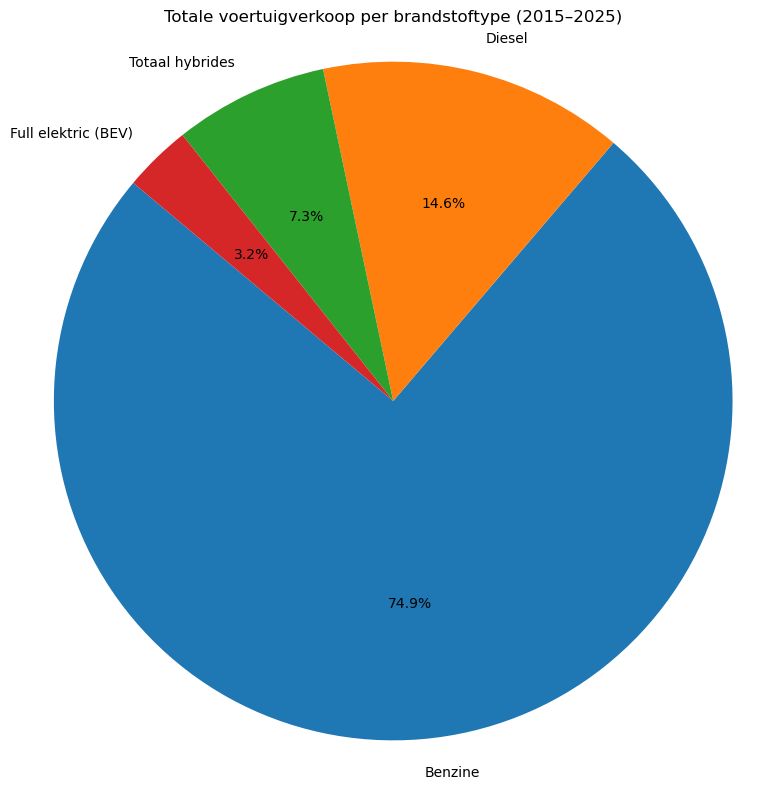

Totale aantallen per brandstof:

Brandstof
Benzine                24,313,032 voertuigen
Diesel                  4,727,905 voertuigen
Totaal hybrides         2,385,886 voertuigen
Full elektric (BEV)     1,047,582 voertuigen
Name: Totaal, dtype: object


In [86]:
import matplotlib.pyplot as plt

# Som van alle verkochte voertuigen per brandstof (2015–2025)
verkoop_per_brandstof = df.groupby('Brandstof')['Totaal'].sum().sort_values(ascending=False)

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    verkoop_per_brandstof,
    labels=verkoop_per_brandstof.index,
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Totale voertuigverkoop per brandstoftype (2015–2025)")
plt.axis('equal')
plt.tight_layout()
plt.show()

# Print totalen in aantallen
print("Totale aantallen per brandstof:\n")
print(verkoop_per_brandstof.astype(int).apply(lambda x: f"{x:,} voertuigen"))



In [87]:
# Zorg dat de outputmap bestaat
import os
output_dir = r"D:\CBS\Werkelijke Aurtoverkoop(test)"
os.makedirs(output_dir, exist_ok=True)

# Groepeer per maand (datum), som van Totaal, Nieuw, Tweedehands
def export_filtered_csv(df_filtered, bestandsnaam):
    df_monthly = df_filtered.groupby('Datum')[['Totaal', 'Nieuw', 'Tweedehands']].sum().reset_index()
    df_monthly = df_monthly.sort_values('Datum')
    output_path = os.path.join(output_dir, bestandsnaam)
    df_monthly.to_csv(output_path, index=False)
    print(f"✅ Bestand opgeslagen: {output_path}")

# 1. Alle voertuigen
export_filtered_csv(df, "verkoop_alle_voertuigen.csv")

# 2. Alleen hybrides
df_hybride = df[df['Brandstof'].str.lower().str.contains('hybride')]
export_filtered_csv(df_hybride, "verkoop_hybride.csv")

# 3. Alleen full elektrisch (BEV)
df_bev = df[df['Brandstof'].str.lower().str.contains('full elektrisch')]
export_filtered_csv(df_bev, "verkoop_full_electric.csv")


✅ Bestand opgeslagen: D:\CBS\Werkelijke Aurtoverkoop(test)\verkoop_alle_voertuigen.csv
✅ Bestand opgeslagen: D:\CBS\Werkelijke Aurtoverkoop(test)\verkoop_hybride.csv
✅ Bestand opgeslagen: D:\CBS\Werkelijke Aurtoverkoop(test)\verkoop_full_electric.csv


In [48]:

display(df)  # Laat de eerste paar rijen van de dataframe zien

,Voertuigtype,Datum,Totaal,Nieuw,Tweedehands,Brandstof,Jaar,VerkoopSchaal5,VerkoopGenorm
0,A018943,2015-01-01,216691,34377,182314,Benzine,2015,5,0.906911
1,A018943,2015-02-01,186837,25389,161448,Benzine,2015,5,0.781852
2,A018943,2015-03-01,196766,19351,177415,Benzine,2015,5,0.823445
3,A018943,2015-04-01,188709,18249,170460,Benzine,2015,5,0.789694
4,A018943,2015-05-01,186681,18175,168506,Benzine,2015,5,0.781199
...,...,...,...,...,...,...,...,...,...
487,A018943,2024-11-01,49940,13709,36231,Totaal hybrides,2024,4,0.208387
488,A018943,2024-12-01,46811,11459,35352,Totaal hybrides,2024,4,0.195280
489,A018943,2025-01-01,54888,14829,40059,Totaal hybrides,2025,4,0.229115
490,A018943,2025-02-01,49695,12395,37300,Totaal hybrides,2025,4,0.207361


Plot 1: Totale verkoop per brandstof (alle voertuigen samen)

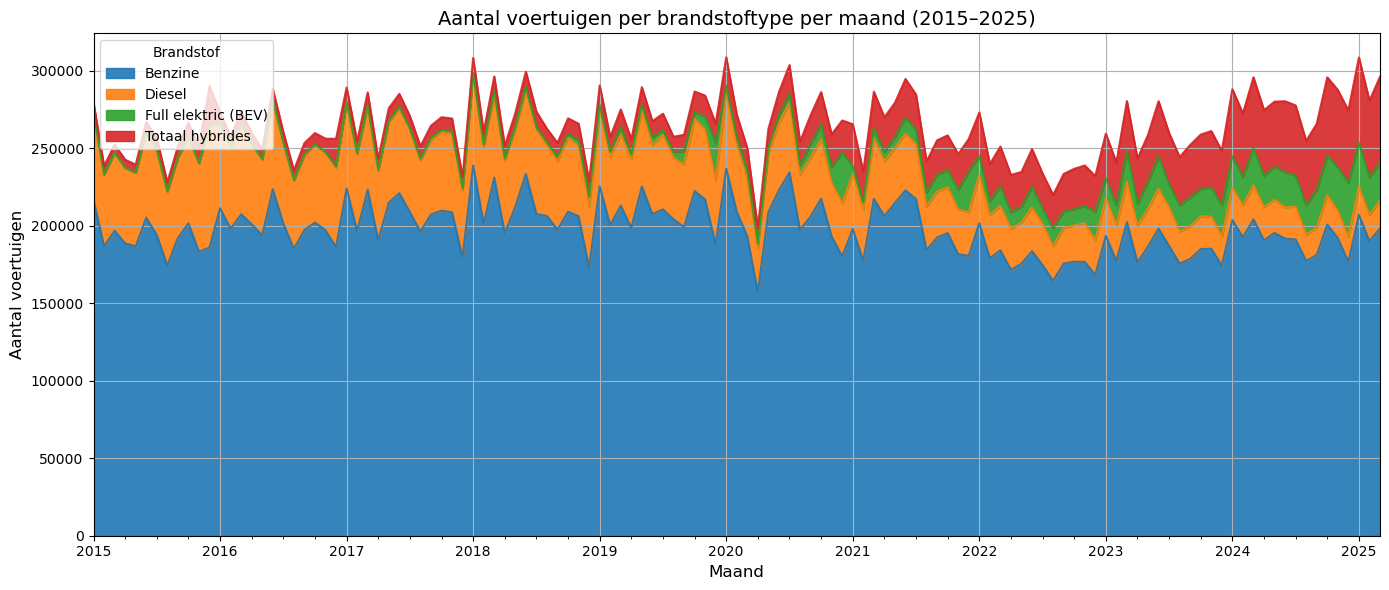

In [26]:
import matplotlib.pyplot as plt

# Groepeer per maand (Datum) en Brandstof, sommeer het totaal aantal verkochte voertuigen
df_monthly = df.groupby(['Datum', 'Brandstof'])['Totaal'].sum().reset_index()

# Pivot: rijen = maand, kolommen = brandstof, waarden = aantallen
df_monthly_pivot = df_monthly.pivot(index='Datum', columns='Brandstof', values='Totaal').fillna(0)

# Plot gestapelde area chart
df_monthly_pivot.plot.area(figsize=(14, 6), alpha=0.9)

plt.title("Aantal voertuigen per brandstoftype per maand (2015–2025)", fontsize=14)
plt.xlabel("Maand", fontsize=12)
plt.ylabel("Aantal voertuigen", fontsize=12)
plt.legend(title="Brandstof", loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()




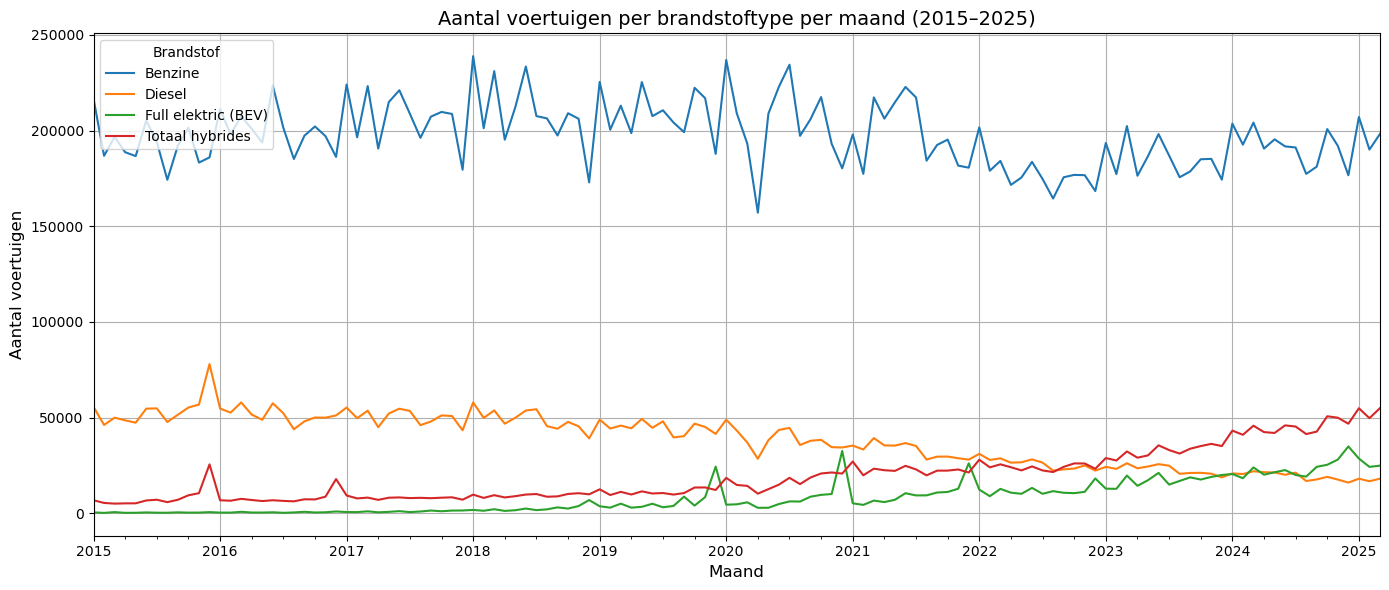

In [27]:
import matplotlib.pyplot as plt

# Groepeer per maand (Datum) en Brandstof, sommeer het totaal aantal verkochte voertuigen
df_monthly = df.groupby(['Datum', 'Brandstof'])['Totaal'].sum().reset_index()

# Pivot: rijen = maand, kolommen = brandstof, waarden = aantallen
df_monthly_pivot = df_monthly.pivot(index='Datum', columns='Brandstof', values='Totaal').fillna(0)

# Line plot
df_monthly_pivot.plot(figsize=(14, 6))  # let op: geen .area, dus lijnplot

plt.title("Aantal voertuigen per brandstoftype per maand (2015–2025)", fontsize=14)
plt.xlabel("Maand", fontsize=12)
plt.ylabel("Aantal voertuigen", fontsize=12)
plt.legend(title="Brandstof", loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Plot 2: Alleen nieuwe voertuigen per brandstof (per maand)

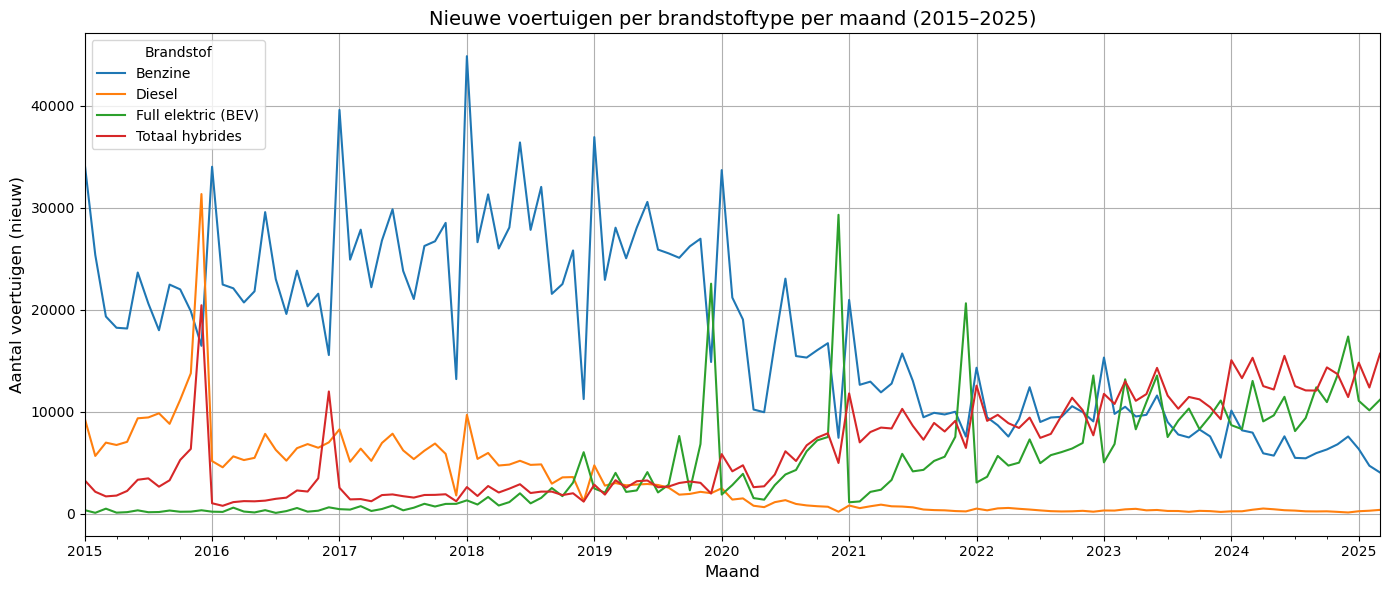

In [28]:
# Groepeer per maand en brandstof, som van nieuwe voertuigen
df_nieuw = df.groupby(['Datum', 'Brandstof'])['Nieuw'].sum().reset_index()
df_nieuw_pivot = df_nieuw.pivot(index='Datum', columns='Brandstof', values='Nieuw').fillna(0)

# Plot lijn
df_nieuw_pivot.plot(figsize=(14, 6))

plt.title("Nieuwe voertuigen per brandstoftype per maand (2015–2025)", fontsize=14)
plt.xlabel("Maand", fontsize=12)
plt.ylabel("Aantal voertuigen (nieuw)", fontsize=12)
plt.legend(title="Brandstof", loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Plot 3: Alleen tweedehands voertuigen per brandstof (per maand)

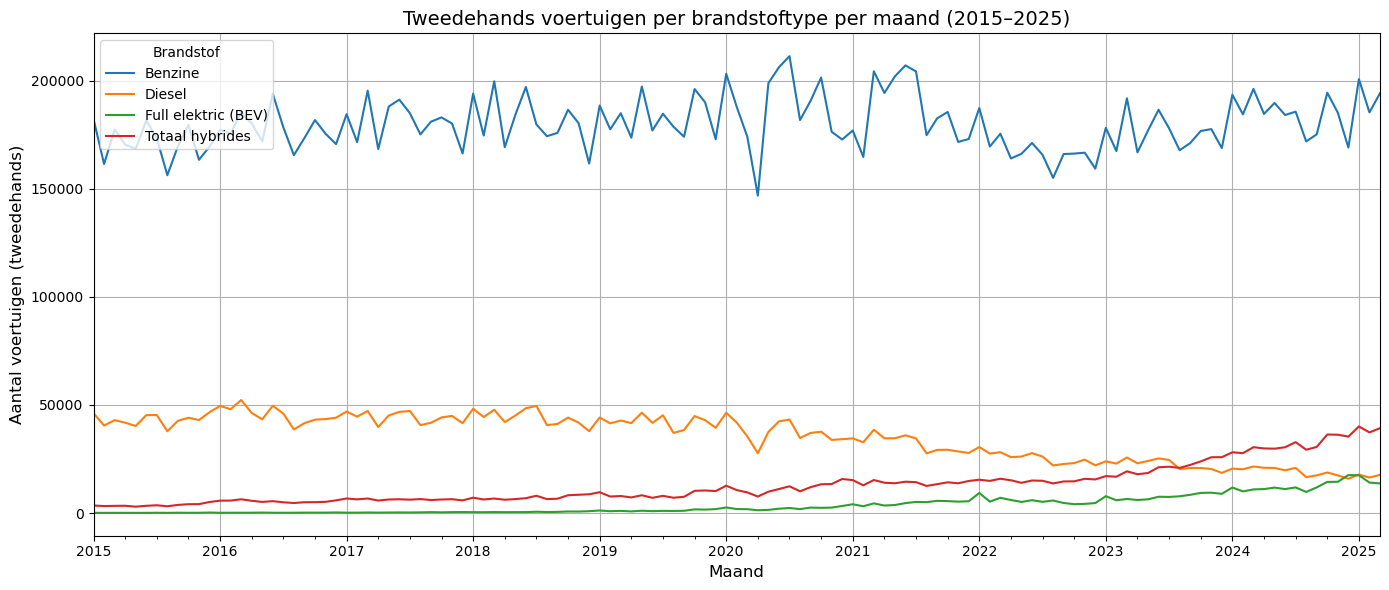

In [29]:
# Groepeer per maand en brandstof, som van tweedehands voertuigen
df_2e = df.groupby(['Datum', 'Brandstof'])['Tweedehands'].sum().reset_index()
df_2e_pivot = df_2e.pivot(index='Datum', columns='Brandstof', values='Tweedehands').fillna(0)

# Plot lijn
df_2e_pivot.plot(figsize=(14, 6))

plt.title("Tweedehands voertuigen per brandstoftype per maand (2015–2025)", fontsize=14)
plt.xlabel("Maand", fontsize=12)
plt.ylabel("Aantal voertuigen (tweedehands)", fontsize=12)
plt.legend(title="Brandstof", loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Plot 4: Alleen elektrische + hybride voertuigen samen (nieuw + tweedehands)

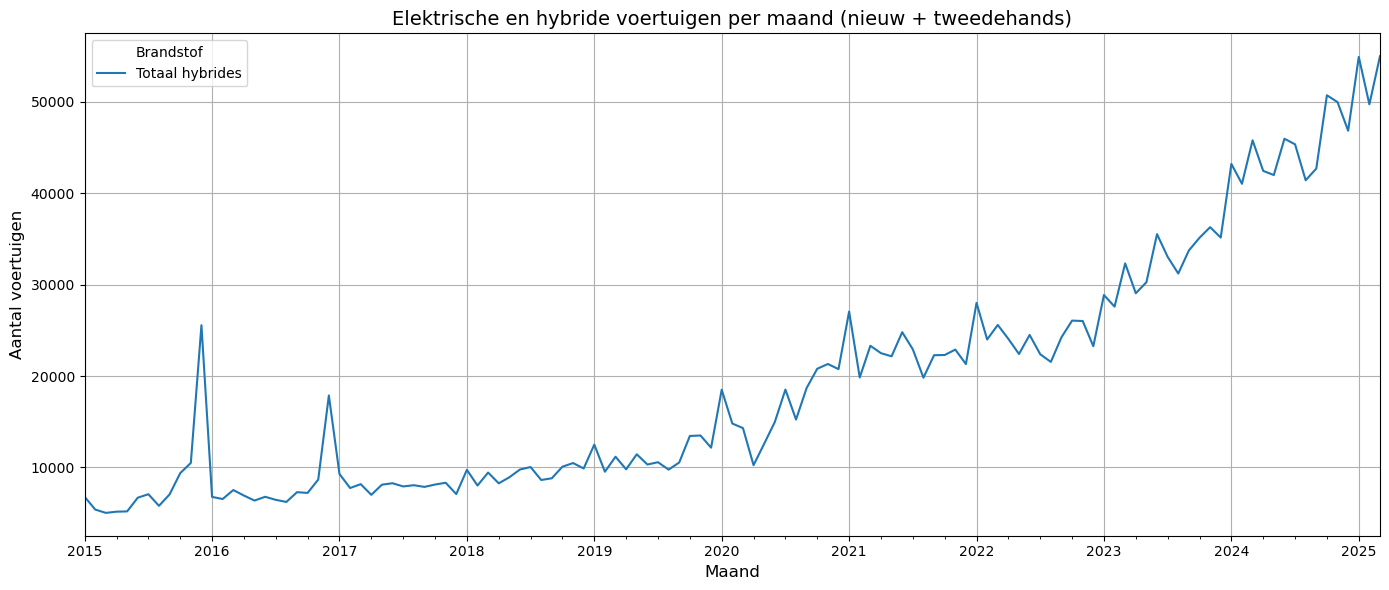

In [88]:
# Filter op alleen elektrische + hybride types (case-insensitief)
df_ev = df[df['Brandstof'].str.contains('elektriciteit|hybride', case=False)]

# Groepeer per maand en brandstof, som van Totaal (nieuw + tweedehands)
df_ev_grouped = df_ev.groupby(['Datum', 'Brandstof'])['Totaal'].sum().reset_index()
df_ev_pivot = df_ev_grouped.pivot(index='Datum', columns='Brandstof', values='Totaal').fillna(0)

# Plot lijn
df_ev_pivot.plot(figsize=(14, 6))

plt.title("Elektrische en hybride voertuigen per maand (nieuw + tweedehands)", fontsize=14)
plt.xlabel("Maand", fontsize=12)
plt.ylabel("Aantal voertuigen", fontsize=12)
plt.legend(title="Brandstof", loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Plot: Alleen Full Electric voertuigen (nieuw + tweedehands) per maand



In [53]:
import pandas as pd

verkoop_path = r"D:\CBS\Werkelijke Aurtoverkoop(test)\verkoop_hybride.csv"
vertrouwen_path = r"D:\CBS\filtered_consumentenvertrouwen_2015_2025.csv"

# Toon alleen kolomnamen
verkoop_cols = pd.read_csv(verkoop_path, nrows=0).columns.tolist()
vertrouwen_cols = pd.read_csv(vertrouwen_path, nrows=0).columns.tolist()

print("Verkoop kolommen:", verkoop_cols)
print("Consumentenvertrouwen kolommen:", vertrouwen_cols)


Verkoop kolommen: ['Datum', 'Totaal', 'Nieuw', 'Tweedehands']
Consumentenvertrouwen kolommen: ['Periode', 'Consumentenvertrouwen_1', 'Koopbereidheid_3', 'EconomischKlimaat_2']


In [62]:
import pandas as pd

# Inlezen
verkoop_path = r"D:\CBS\Werkelijke Aurtoverkoop(test)\verkoop_hybride.csv"
vertrouwen_path = r"D:\CBS\filtered_consumentenvertrouwen_2015_2025.csv"

verkoop_df = pd.read_csv(verkoop_path)
vertrouwen_df = pd.read_csv(vertrouwen_path)

# Zorg dat de datums kloppen
verkoop_df['Datum'] = pd.to_datetime(verkoop_df['Datum'])
vertrouwen_df['Periode'] = pd.to_datetime(vertrouwen_df['Periode'])

# Stap 1: groepeer verkoopdata per maand
verkoop_per_maand = verkoop_df.groupby('Datum', as_index=False).mean(numeric_only=True)

# Stap 2: hernoem kolom zodat ze kunnen matchen
verkoop_per_maand = verkoop_per_maand.rename(columns={'Datum': 'Periode'})

# Stap 3: merge met vertrouwen op 'Periode' (nu 1-op-1)
combined_df = pd.merge(verkoop_per_maand, vertrouwen_df, on='Periode', how='outer')

# Stap 4: sorteer op tijd
combined_df = combined_df.sort_values(by='Periode')

# Opslaan
combined_df.to_csv(r"D:\CBS\combined_data_cleaned.csv", index=False)

print("✅ Bestand succesvol opgeschoond en opgeslagen!")


✅ Bestand succesvol opgeschoond en opgeslagen!


In [96]:
kut_zooi= r"D:\CBS\Werkelijke Aurtoverkoop(test)\verkoop_hybride.csv"
display(kut_zooi)  # Laat de eerste paar rijen van de dataframe zien





'D:\\CBS\\Werkelijke Aurtoverkoop(test)\\verkoop_hybride.csv'

In [98]:
import pandas as pd

kut_zooi = 'D:\\CBS\\Werkelijke Aurtoverkoop(test)\\verkoop_hybride.csv'
df = pd.read_csv(kut_zooi)

display(df.head())


,Datum,Totaal,Nieuw,Tweedehands
0,2015-01-01,6793,3308,3485
1,2015-02-01,5397,2177,3220
2,2015-03-01,5036,1724,3312
3,2015-04-01,5168,1803,3365
4,2015-05-01,5198,2256,2942


In [101]:
output_path = r"D:\pomp_en_autoverkoop.csv"
df_combined.to_csv(output_path, index=False)
print(f"✅ Bestand opgeslagen: {output_path}")


✅ Bestand opgeslagen: D:\pomp_en_autoverkoop.csv


,Periode,Totaal_x,Nieuw_x,Tweedehands_x,Totaal_y,Nieuw_y,Tweedehands_y,Consumentenvertrouwen_1,Koopbereidheid_3,EconomischKlimaat_2
0,2015-01,6793.0,3308.0,3485.0,6793.0,3308.0,3485.0,9.583333,-1.583333,26.250000
1,2015-02,5397.0,2177.0,3220.0,5397.0,2177.0,3220.0,NaN,NaN,NaN
2,2015-03,5036.0,1724.0,3312.0,5036.0,1724.0,3312.0,NaN,NaN,NaN
3,2015-04,5168.0,1803.0,3365.0,5168.0,1803.0,3365.0,NaN,NaN,NaN
4,2015-05,5198.0,2256.0,2942.0,5198.0,2256.0,2942.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
118,2024-11,49940.0,13709.0,36231.0,49940.0,13709.0,36231.0,NaN,NaN,NaN
119,2024-12,46811.0,11459.0,35352.0,46811.0,11459.0,35352.0,NaN,NaN,NaN
120,2025-01,54888.0,14829.0,40059.0,54888.0,14829.0,40059.0,-31.333333,-16.333333,-53.666667
121,2025-02,49695.0,12395.0,37300.0,49695.0,12395.0,37300.0,NaN,NaN,NaN


In [103]:
import pandas as pd

# Paden naar de bestanden
vertrouwen_path = r"D:\CBS\vertrouwen_clean_datefix.csv"
pomp_en_verkoop_path = r"D:\pomp_en_autoverkoop.csv"

# Inlezen
vertrouwen_df = pd.read_csv(vertrouwen_path)
pomp_verkoop_df = pd.read_csv(pomp_en_verkoop_path)

# Zorg dat 'Periode' in beide datasets goed staat
vertrouwen_df['Periode'] = pd.to_datetime(vertrouwen_df['Periode']).dt.to_period('M').astype(str)
pomp_verkoop_df['Periode'] = pd.to_datetime(pomp_verkoop_df['Periode']).dt.to_period('M').astype(str)

# Merge op 'Periode'
final_df = pd.merge(pomp_verkoop_df, vertrouwen_df, on='Periode', how='outer')

# Sorteren op tijd
final_df = final_df.sort_values('Periode')

# Opslaan
output_path = r"D:\CBS\alles_samengevoegd_definitief.csv"
final_df.to_csv(output_path, index=False)

final_df.head()


,Periode,Totaal_x,Nieuw_x,Tweedehands_x,Totaal_y,Nieuw_y,Tweedehands_y,Consumentenvertrouwen_1_x,Koopbereidheid_3_x,EconomischKlimaat_2_x,Consumentenvertrouwen_1_y,Koopbereidheid_3_y,EconomischKlimaat_2_y
0,2015-01,6793.0,3308.0,3485.0,6793.0,3308.0,3485.0,9.583333,-1.583333,26.25,-2.0,-8.0,6.0
1,2015-01,6793.0,3308.0,3485.0,6793.0,3308.0,3485.0,9.583333,-1.583333,26.25,-1.0,-6.0,6.0
2,2015-01,6793.0,3308.0,3485.0,6793.0,3308.0,3485.0,9.583333,-1.583333,26.25,7.0,-4.0,22.0
3,2015-01,6793.0,3308.0,3485.0,6793.0,3308.0,3485.0,9.583333,-1.583333,26.25,10.0,-4.0,30.0
4,2015-01,6793.0,3308.0,3485.0,6793.0,3308.0,3485.0,9.583333,-1.583333,26.25,11.0,-3.0,31.0
